In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ..

/Share/home/shibinbin/projects/exRNA


In [160]:
import pandas as pd
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression

In [292]:
def alignment_score(X, y, K=10):
    N = X.shape[0]
    nn = NearestNeighbors(K)
    nn.fit(X)

    distances, indices = nn.kneighbors(X, K + 1)
    neighbor_classes = np.take(y, indices[:, 1:])
    same_class_fractions = np.sum(neighbor_classes == y[:, np.newaxis], axis=1)
    score = 1.0 - (np.mean(same_class_fractions) - K/N)/(K - K/N)
    return score

def knn_score(X, y, K=10):
    N = X.shape[0]
    assert K < N
    nn = NearestNeighbors(K)
    nn.fit(X)
    
    distances, indices = nn.kneighbors(X, K + 1)
    neighbor_classes = np.take(y, indices[:, 1:])
    same_class_fractions = np.sum(neighbor_classes == y[:, np.newaxis], axis=1)
    classes, counts = np.unique(y, return_counts=True)
    classes = np.argmax(y.reshape((-1, 1)) == classes.reshape((1, -1)), axis=1)
    counts = np.take(counts, classes)
    mean_r = K/(N - 1)*counts
    max_r = np.minimum(K, counts)
    scores = (same_class_fractions - mean_r)/(max_r - mean_r)
    #print(scores)
    return scores.mean()

In [23]:
cpm = pd.read_table('output/cpm_matrix/GSE71008.txt', sep='\t', index_col=0)

In [197]:
m1.columns.shape

(192,)

In [232]:
m1 = pd.read_table('output/count_matrix/GSE71008_original.txt', sep='\t', index_col=0)
m2 = pd.read_csv('/home/chenxupeng/projects/training/data/gse_exp_ly.csv', index_col=0)
m1.columns = 'Sample_' + m1.columns
#m2 = m2.reindex(columns=m1.columns.values)

In [243]:
np.setdiff1d(m2.columns.values, m1.columns.values)

array([], dtype=object)

In [233]:
m1.head()

,Sample_1S1,Sample_1S2,Sample_1S3,Sample_2S1,Sample_2S2,Sample_2S3,Sample_3S1,Sample_3S2,Sample_3S3,Sample_4S1,...,Sample_1S17,Sample_N31,Sample_N33,Sample_N35,Sample_N36,Sample_1S21,Sample_4S20,Sample_N37,Sample_1S23,Sample_N44
ID,,,,,,,,,,,,,,,,,,,,,
A-NT2RP7011570,11,10,6,0,9,8,0,10,10,11,...,0,3,0,0,4,4,0,2,4,2
C-ADG04260,1,1,1,1,1,2,1,2,1,1,...,1,1,1,1,0,1,1,1,1,1
C-ADG07684,2,3,5,3,5,4,5,4,4,7,...,4,3,3,4,5,3,2,1,0,4
C-ASTRO3000154,9,9,10,5,11,11,12,10,9,14,...,4,5,4,5,8,5,4,4,0,5
C-BRACE2001543,0,0,0,0,0,0,0,1,0,0,...,2,2,2,6,2,4,4,1,2,2


In [318]:
m2.iloc[:5, :15]

,Sample_1S3,Sample_1S6,Sample_1S9,Sample_1S12,Sample_1S15,Sample_1S18,Sample_1S21,Sample_1S24,Sample_4S2,Sample_4S5,Sample_4S8,Sample_4S11,Sample_4S14,Sample_4S17,Sample_4S20
geneid,,,,,,,,,,,,,,,
A-NT2RP7011570,3,0,0,6,8,10,1,0,0,8,4,0,9,7,3
C-ADG04260,0,1,1,1,2,1,2,0,1,1,1,2,2,1,2
C-ADG07684,3,3,13,5,4,4,4,6,2,7,4,1,1,0,2
C-ASTRO3000154,8,8,8,10,11,9,13,15,7,8,5,0,1,1,8
C-BRACE2001543,0,0,0,0,0,0,0,0,2,0,2,0,0,1,0


In [252]:
sim_matrix = np.zeros((m1.shape[1], m1.shape[1]), dtype=np.int32)
for i in range(m1.shape[1]):
    for j in range(m2.shape[1]):
        sim_matrix[i, j] = np.sum(np.abs(m1.iloc[:, i] - m2.iloc[:, j]))

In [289]:
sample_mappings = pd.DataFrame({
    'Sample1': m1.columns[:150].values,
    'Class1': sample_classes[m1.columns[:150]].values,
    'Sample2': m2.columns[np.argmin(sim_matrix, axis=1)[:150]].values,
    'Class2': sample_classes[m2.columns[np.argmin(sim_matrix, axis=1)[:150]]].values
}).reindex(columns=['Sample1', 'Class1', 'Sample2', 'Class2'])
sample_mappings.head(20)

,Sample1,Class1,Sample2,Class2
0,Sample_1S1,Colorectal Cancer,Sample_1S10,Colorectal Cancer
1,Sample_1S2,Colorectal Cancer,Sample_1S11,Colorectal Cancer
2,Sample_1S3,Colorectal Cancer,Sample_1S12,Colorectal Cancer
3,Sample_2S1,Colorectal Cancer,Sample_1S13,Colorectal Cancer
4,Sample_2S2,Colorectal Cancer,Sample_1S14,Colorectal Cancer
5,Sample_2S3,Colorectal Cancer,Sample_1S15,Colorectal Cancer
6,Sample_3S1,Colorectal Cancer,Sample_1S16,Colorectal Cancer
7,Sample_3S2,Colorectal Cancer,Sample_1S17,Colorectal Cancer
8,Sample_3S3,Colorectal Cancer,Sample_1S18,Colorectal Cancer
9,Sample_4S1,Colorectal Cancer,Sample_1S19,Colorectal Cancer


In [219]:
sim_matrix[np.r_[:192], np.r_[:192]] = 1000000

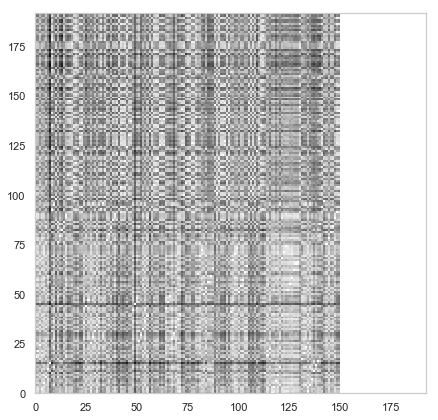

In [253]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.pcolor(sim_matrix, cmap=cm.Greys)

In [185]:
counts_original = pd.read_table('output/count_matrix/GSE71008_original.txt', sep='\t', index_col=0)
counts_original = pd.read_csv('/home/chenxupeng/projects/training/data/gse_exp_ly.csv', index_col=0)
#counts_original.columns = 'Sample_' + counts_original.columns
counts_original.head()
cpm_original = counts_original*1e6/counts_original.sum(axis=0)
cpm_original.head()

,Sample_1S3,Sample_1S6,Sample_1S9,Sample_1S12,Sample_1S15,Sample_1S18,Sample_1S21,Sample_1S24,Sample_4S2,Sample_4S5,...,Sample_4S1,Sample_4S4,Sample_4S7,Sample_4S10,Sample_4S13,Sample_4S16,Sample_4S19,Sample_4S22,Sample_4S25,Sample_N49
geneid,,,,,,,,,,,,,,,,,,,,,
A-NT2RP7011570,3.016928,0.000000,0.000000,6.041536,8.056719,10.084142,1.008223,0.000000,0.000000,8.065150,...,0.00000,4.016818,0.000000,5.027556,12.062084,8.041866,0.000000,1.006785,0.000000,0.000000
C-ADG04260,0.000000,1.007246,1.007373,1.006923,2.014180,1.008414,2.016446,0.000000,1.004125,1.008144,...,1.00823,1.004205,0.000000,2.011022,2.010347,1.005233,1.003957,2.013569,1.004399,1.004471
C-ADG07684,3.016928,3.021738,13.095849,5.034613,4.028360,4.033657,4.032892,6.095312,2.008250,7.057006,...,1.00823,2.008409,3.010763,3.016534,1.005174,0.000000,1.003957,3.020354,3.013198,3.013413
C-ASTRO3000154,8.045141,8.057969,8.058984,10.069226,11.077989,9.075728,13.106900,15.238281,7.028875,8.065150,...,0.00000,4.016818,2.007176,8.044090,0.000000,0.000000,0.000000,12.081417,5.021996,2.008942
C-BRACE2001543,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.008250,0.000000,...,0.00000,2.008409,2.007176,0.000000,0.000000,0.000000,0.000000,0.000000,2.008799,1.004471


In [12]:
normalized = pd.read_table('tmp/scnorm.GSE71008.txt')
print('number of samples: {}, features: {}'.format(*normalized.shape))
normalized.head()

number of samples: 3000, features: 192


,Sample_1S10,Sample_1S11,Sample_1S12,Sample_1S13,Sample_1S14,Sample_1S15,Sample_1S16,Sample_1S17,Sample_1S18,Sample_1S19,...,Sample_PC34,Sample_PC35,Sample_PC36,Sample_PC3,Sample_PC4,Sample_PC5,Sample_PC6,Sample_PC7,Sample_PC8,Sample_PC9
ENST00000384906.1|MIR99A-201|81,392375.572286,356175.409112,262760.560264,292465.280392,271792.124742,286340.396918,292269.526569,272744.455357,276654.622228,322559.515968,...,337048.883719,312128.646931,324701.563522,310641.456108,312091.501049,273229.494396,353763.733500,297027.547264,360242.814186,374539.494880
ENST00000362190.3|MIR22-201|85,106265.515638,124434.658818,234766.271881,105749.428540,105414.308481,78513.730369,131783.478408,198838.243040,145613.053017,157998.210725,...,112341.667242,118012.493756,211012.226784,151101.999981,336119.284677,266966.921167,211976.798625,175087.739272,130945.798748,139673.032171
ENST00000385302.1|MIR320A-201|82,81773.136625,87453.380632,236510.691798,62185.851262,66235.265726,59297.001129,89077.058732,162979.800361,158395.266612,113501.764625,...,67189.506996,76109.649105,115377.365729,105101.820582,311673.506715,285067.355886,172731.943310,178436.672615,98787.984255,100388.085952
ENST00000385259.1|MIR100-201|80,112415.973156,110441.899880,129246.445491,96668.801718,77016.698632,82258.292506,98998.712584,96374.286779,96874.182321,100456.212892,...,94017.928288,92201.148086,133212.983577,94139.248481,134565.603727,108612.709096,118903.174972,99896.726035,105794.193391,98491.091490
ENST00000362309.3|MIRLET7I-201|84,95513.521187,80780.355684,74667.958095,127697.160529,89701.998045,67401.730079,101272.138543,101158.416468,73872.518233,123121.466620,...,92389.415085,90373.612672,151266.646288,71555.874125,78708.862166,66808.787813,71330.234981,57141.367581,75103.383234,73359.583641


In [16]:
sample_classes = pd.read_table('metadata/sample_classes.GSE71008.txt', sep='\t', header=None,
                               names=['sample_id', 'label'], index_col=0).iloc[:, 0]
unique_classes = np.unique(sample_classes)
print('Unique classes: {}'.format(', '.join(unique_classes)))
sample_classes.head()

Unique classes: Colorectal Cancer, Healthy Control, Pancreatic Cancer, Prostate Cancer


sample_id
Sample_1S3     Colorectal Cancer
Sample_1S6     Colorectal Cancer
Sample_1S9     Colorectal Cancer
Sample_1S12    Colorectal Cancer
Sample_1S15    Colorectal Cancer
Name: label, dtype: object

In [330]:
cpm_original.columns

Index(['Sample_1S1', 'Sample_1S2', 'Sample_1S3', 'Sample_2S1', 'Sample_2S2',
       'Sample_2S3', 'Sample_3S1', 'Sample_3S2', 'Sample_3S3', 'Sample_4S1',
       ...
       'Sample_1S17', 'Sample_N31', 'Sample_N33', 'Sample_N35', 'Sample_N36',
       'Sample_1S21', 'Sample_4S20', 'Sample_N37', 'Sample_1S23',
       'Sample_N44'],
      dtype='object', length=192)

Alignment score: 0.11964863407378375


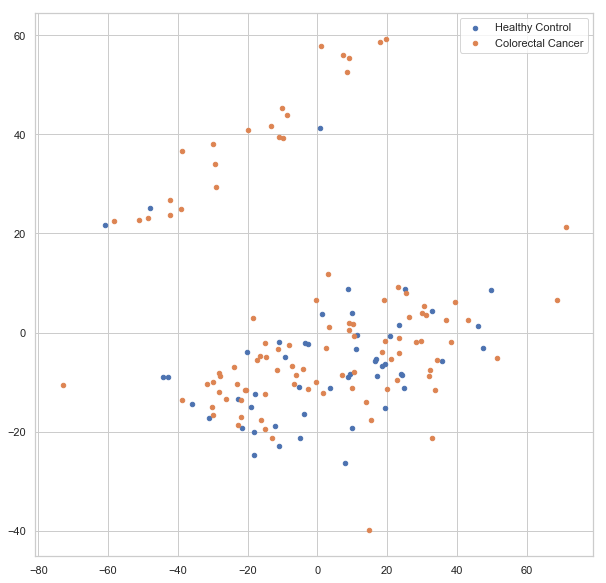

In [336]:
counts_original = pd.read_table('output/count_matrix/GSE71008_original.txt', sep='\t', index_col=0)
counts_original.columns = 'Sample_' + counts_original.columns
counts_original.head()
cpm_original = counts_original*1e6/counts_original.sum(axis=0)

X = np.log2(cpm_original + 1).T
#X = cpm_original.T.copy()
X = StandardScaler().fit_transform(X)
#pca = TSNE(2)
pca = PCA()
#pca.fit(X)
X_pca = pca.fit_transform(X)

fig, ax = plt.subplots(figsize=(10, 10))
for label in ['Healthy Control', 'Colorectal Cancer']:
    indices = np.nonzero(sample_classes[cpm_original.columns.values] == label)[0]
    ax.scatter(X_pca[indices, 0], X_pca[indices, 1], s=20, label=label)
ax.legend()

print('Alignment score: {}'.format(knn_score(X_pca, sample_classes[cpm_original.columns.values].values)))
f

Alignment score: 0.6699946402803546


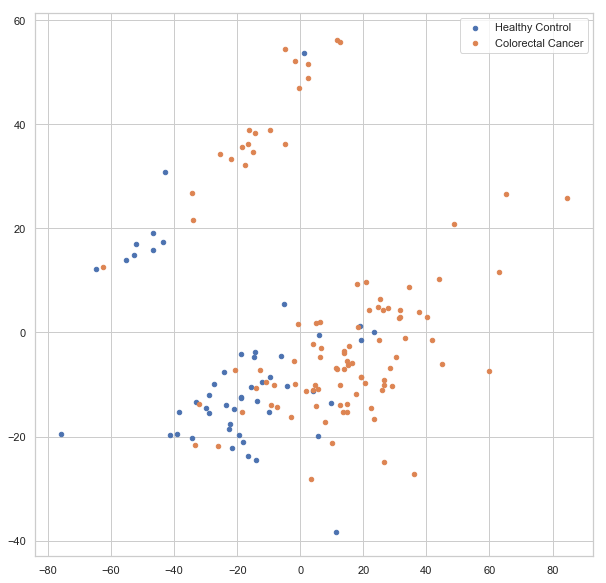

In [320]:
counts_original = pd.read_csv('/home/chenxupeng/projects/training/data/gse_exp_ly.csv', index_col=0)
cpm_original = counts_original*1e6/counts_original.sum(axis=0)

X = np.log2(cpm_original + 1).T
#X = cpm_original.T.copy()
X = StandardScaler().fit_transform(X)
#pca = TSNE(2)
pca = PCA()
#pca.fit(X)
X_pca = pca.fit_transform(X)

fig, ax = plt.subplots(figsize=(10, 10))
for label in ['Healthy Control', 'Colorectal Cancer']:
    indices = np.nonzero(sample_classes[cpm_original.columns.values] == label)[0]
    ax.scatter(X_pca[indices, 0], X_pca[indices, 1], s=20, label=label)
ax.legend()

print('Alignment score: {}'.format(knn_score(X_pca, sample_classes[cpm_original.columns.values].values)))

In [ ]:
X = np.log2(cpm.loc[normalized.index.values] + 1).T
X = StandardScaler().fit_transform(X)
pca = PCA()
pca.fit(X)
X_pca = pca.transform(X)

fig, ax = plt.subplots(figsize=(10, 10))
for label in unique_classes:
    indices = np.nonzero(sample_classes == label)[0]
    ax.scatter(X_pca[indices, 0], X_pca[indices, 1], s=20, label=label)
ax.legend()

print('Alignment score: {}'.format(knn_score(X_pca, sample_classes)))

Alignment score: 0.5895287958115183


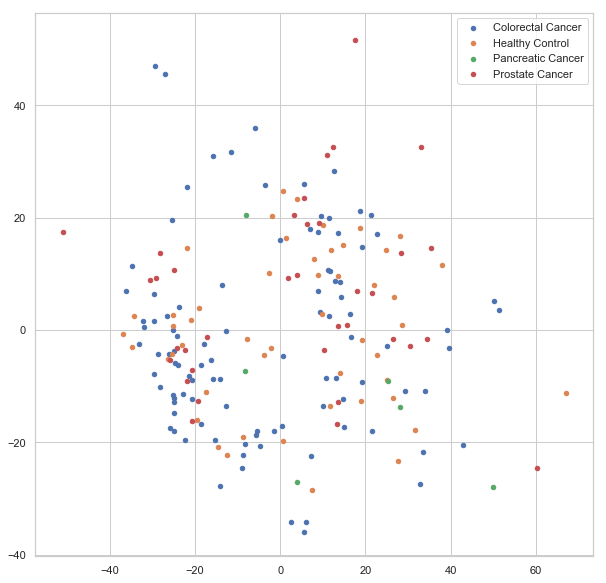

In [61]:
X = np.log2(normalized + 1).T
X = StandardScaler().fit_transform(X)
pca = PCA()
pca.fit(X)
X_pca = pca.transform(X)

fig, ax = plt.subplots(figsize=(10, 10))
for label in unique_classes:
    indices = np.nonzero(sample_classes == label)[0]
    ax.scatter(X_pca[indices, 0], X_pca[indices, 1], s=20, label=label)
ax.legend()

K = 10
N = X.shape[0]
nn = NearestNeighbors(K)
nn.fit(X)

distances, indices = nn.kneighbors(X, K + 1)
neighbor_classes = np.take(sample_classes.values, indices[:, 1:])
same_class_fractions = np.sum(neighbor_classes == sample_classes.values[:, np.newaxis], axis=1)
alignment_score = 1.0 - (np.mean(same_class_fractions) - K/N)/(K - K/N)
print('Alignment score: {}'.format(alignment_score))

In [51]:
same_class_fractions

array([4, 5, 7, 7, 6, 8, 7, 5, 6, 3, 1, 3, 8, 4, 6, 4, 3, 4, 4, 3, 3, 3,
       2, 4, 2, 8, 7, 7, 6, 8, 7, 3, 5, 7, 6, 7, 5, 4, 3, 6, 2, 5, 3, 4,
       4, 4, 3, 7, 4, 3, 6, 7, 7, 5, 6, 7, 2, 2, 1, 0, 5, 1, 4, 1, 3, 1,
       2, 1, 1, 3, 2, 2, 3, 2, 6, 7, 7, 8, 7, 8, 0, 2, 1, 2, 2, 4, 1, 2,
       0, 3, 2, 2, 1, 1, 1, 1, 5, 6, 8, 8, 7, 6, 5, 4, 3, 3, 6, 4, 5, 4,
       3, 4, 0, 0, 3, 3, 1, 2, 1, 2, 7, 6, 7, 7, 4, 6, 7, 5, 7, 4, 2, 2,
       3, 4, 2, 3, 1, 1, 0, 3, 2, 3, 1, 1, 4, 1, 4, 5, 8, 7, 6, 6, 7, 7,
       4, 5, 3, 4, 5, 5, 6, 0, 0, 0, 3, 3, 2, 2, 9, 7, 8, 6, 9, 6, 7, 9,
       7, 5, 7, 9, 8, 4, 7, 8, 5, 4, 1, 1, 0, 3, 2, 2])

In [314]:
batch_info = pd.read_excel('metadata/batch_info.GSE71008.xlsx', index_col=0)
batch_types = ('RNA Isolation batch', 'library prepration day', 'gel cut size selection')
print('RNA Isolation batch: {}'.format(', '.join(np.unique(batch_info['RNA Isolation batch'].astype('str')))))
print('Library preparation day: {}'.format(', '.join(np.unique(batch_info['library prepration day'].astype('str')))))
print('Gel cut size selection: {}'.format(', '.join(np.unique(batch_info['gel cut size selection'].astype('str')))))
batch_info.index = 'Sample_' + batch_info.index.values
batch_info.head()

RNA Isolation batch: 1, 2, 3, 4, 5, 6, 7, 8, 9
Library preparation day: 22, 23, 24, 25, 26
Gel cut size selection: 1, 10, 11, 12, 2, 3, 4, 5, 6, 7, 8, 9


,RNA Isolation batch,library prepration day,gel cut size selection
Sample_1S1,2,22,7
Sample_1S2,2,22,8
Sample_1S3,2,22,1
Sample_2S1,2,22,2
Sample_2S2,2,22,3


In [91]:
cpm_mean = np.exp(np.mean(np.log(cpm + 0.01), axis=1)) - 0.01

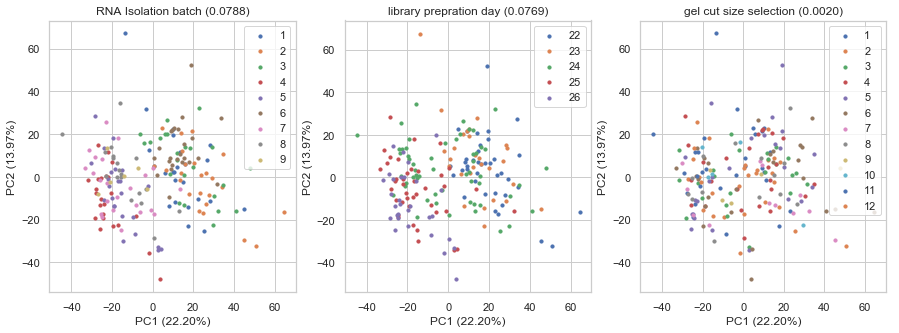

In [317]:
X = np.log2(cpm.loc[cpm_mean > 1] + 1).T
X = StandardScaler().fit_transform(X)
pca = PCA()
pca.fit(X)
X_pca = pca.transform(X)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, batch_type in enumerate(batch_types):
    ax = axes[i]
    labels = batch_info.loc[cpm.columns.values, batch_type].values
    for label in np.unique(labels):
        indices = np.nonzero(labels == label)[0]
        ax.scatter(X_pca[indices, 0], X_pca[indices, 1], s=10, label=label)
    ax.set_title('{} ({:.4f})'.format(batch_type, knn_score(X[:, [0, 1]], labels, K=5)))
    ax.set_xlabel('PC1 ({:.2f}%)'.format(pca.explained_variance_ratio_[0]*100))
    ax.set_ylabel('PC2 ({:.2f}%)'.format(pca.explained_variance_ratio_[1]*100))
    ax.legend()

In [120]:
model = LogisticRegression()
batch_type = batch_types[2]
model.fit(X_pca[:, [0, 1]], batch_info.loc[:, batch_type].values)
model.score(X_pca[:, [0, 1]], batch_info.loc[:, batch_type].values)

0.19270833333333334

In [129]:
X_rand = np.random.normal(size=(1000, 100))
y_rand = np.random.randint(10, size=X_rand.shape[0])
alignment_score(X_rand, y_rand, K=10)

0.8995995995995996

In [145]:
K = 5
N = X_rand.shape[0]
nn = NearestNeighbors(K)
nn.fit(X_rand)
distances, indices = nn.kneighbors(X_rand, K + 1)
neighbor_classes = np.take(y_rand, indices[:, 1:])
same_class_fractions = np.sum(neighbor_classes == y_rand[:, np.newaxis], axis=1)
score = 1.0 - (np.mean(same_class_fractions) - K/N)/(K - K/N)

In [133]:
indices

array([[  0, 294, 351, ..., 310, 821, 928],
       [  1, 577, 248, ..., 922, 658, 575],
       [  2, 356, 453, ..., 502, 929, 664],
       ...,
       [997, 956,  79, ..., 809, 653, 192],
       [998, 955, 956, ..., 632, 453, 816],
       [999, 169, 911, ..., 689, 158, 366]])

In [146]:
np.mean(np.sum(neighbor_classes == y_rand[:, np.newaxis], axis=1))

0.511

In [142]:
indices[:, 1:]

array([[294, 351, 146, ..., 310, 821, 928],
       [577, 248, 956, ..., 922, 658, 575],
       [356, 453, 109, ..., 502, 929, 664],
       ...,
       [956,  79, 891, ..., 809, 653, 192],
       [955, 956, 615, ..., 632, 453, 816],
       [169, 911, 577, ..., 689, 158, 366]])